# Music Score Segmentation Into Staff Lines

This notebook contains an algorithm which takes in an image of a music sheet and outputs a list of images of the lines it contains. The algorithm is based on DBSCAN. Although simple and intuitive, this algorithm may not always give the correct segmentation as some lines in a complicated score may be too close together. In comparison, a neural network may achieve better accuracy and can be way more efficient at test time. However, to train a neural network one would need to label the scores (e.g. by bounding boxes) first, which is not needed in this unsupervised algorithm. This algorithm can therefore be used to label bounding boxes of staff lines so that only a small fraction of scores are mislabeled and can be dealt with separately (e.g. by adjusting the parameters `epsilon` and `min_sample` or manually adjusting the bounding boxes), and the labeled scores can then be fed as input into a neural network.

In [1]:
# importing libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

(694, 1744)


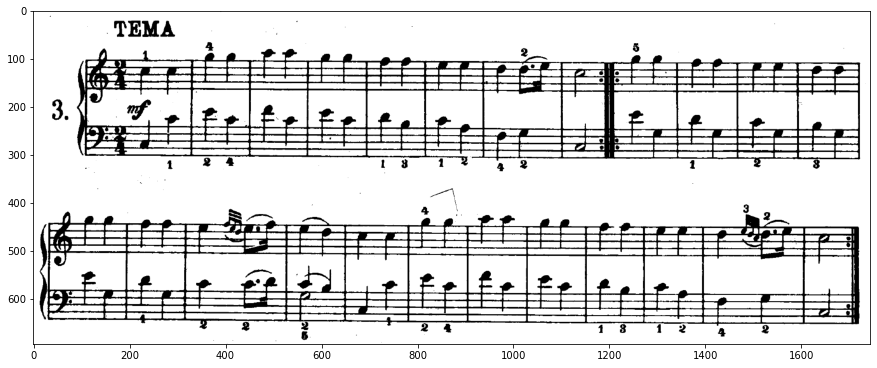

In [2]:
# plotting the image
IMG = cv2.imread('sample_score.png', cv2.IMREAD_GRAYSCALE)
img = IMG
# img = cv2.resize(img, (int(128*img.shape[1]/img.shape[0]),128))
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(img, cmap = plt.cm.gray)
print(img.shape)

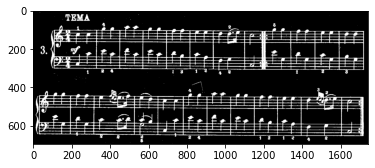

In [3]:
# thresholding and inverting the image so that the black pixels take the value 1 and white pixels 0
img[img < 128] = 1
img[img >=128] = 0
plt.imshow(img, cmap = plt.cm.gray)

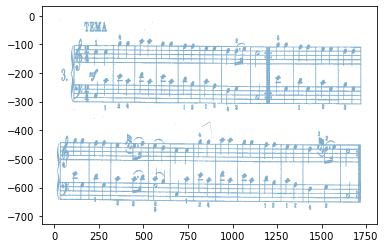

In [4]:
# X = indices of the data points
X = np.argwhere(img==1)
plt.scatter(X[:,1], -X[:,0], s=0.05, edgecolors= 'none')

In [5]:
# # search for good parameters
# for eps in [30, 40]:
#     for min_samples in [30, 60, 90]:
#         clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
#         print(eps, min_samples, len(set(clustering.labels_)))

In [6]:
clustering = DBSCAN(eps=40, min_samples=100).fit(X)
labels = clustering.labels_
set(labels)

{-1, 0, 1}

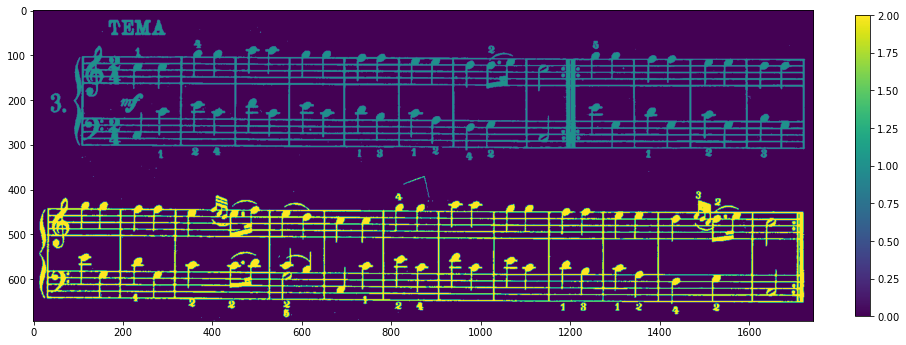

In [7]:
# plot the clusters
temp = np.zeros(img.shape)
for label in set(labels):
    for point in X[labels==label]:
        point = tuple(point)
        temp[point] = label + 1
fig, ax = plt.subplots(figsize=(15,10))
im = ax.imshow(temp)
plt.colorbar(im, ax=ax, fraction=0.018)

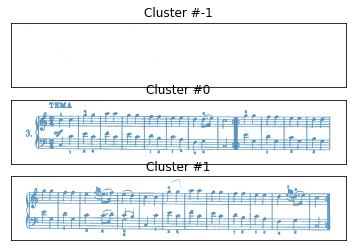

In [8]:
# another way to plot the results
fig, ax = plt.subplots(len(set(labels)))
for label in np.unique(labels):
    ax[label+1].scatter(X[labels==label][:,1], -X[labels==label][:,0], s=0.05, edgecolors= 'none')
    ax[label+1].set_xticks([])
    ax[label+1].set_yticks([])
    ax[label+1].title.set_text('Cluster #%d'%label)

In [9]:
# now we segment the original image into lines of staffs
lines = np.unique(labels)
lines = lines[np.where(lines!=-1)] # remove the 'noise'
lines = np.sort(lines)

In [10]:
lineImg = []
for line in lines:
    cluster = X[labels==line] # indices of the points in a specific line
    xmin = min(cluster[:,1])
    xmax = max(cluster[:,1])
    ymin = min(cluster[:,0])
    ymax = max(cluster[:,0])    
    lineImg.append(IMG[ymin:ymax+1, xmin:xmax+1])

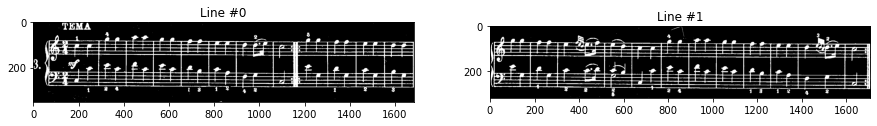

In [11]:
fig, ax = plt.subplots(1,len(lines), figsize=(15,10))
for line in lines:
    ax[line].imshow(lineImg[line], cmap = plt.cm.gray)
    ax[line].imshow(lineImg[line], cmap = plt.cm.gray)
    ax[line].title.set_text('Line #%d'%line)

Now combining all the steps into one function:

In [41]:
def GetLineImages(img):
    '''the following function takes in a grayscale image of a music sheet and outputs a list of subimages 
    that contain each line of the score'''
    # Step 1: Thresholding to eliminate noise and convert grayscale to binary
    IMG = np.copy(img)
    threshold = 128
    img[img < threshold] = 1
    img[img >=threshold] = 0
    
    # Step 2: Get the indices of the remaining patterns in the image
    X = np.argwhere(img==1)
    
    # Step 3: Perform DBSCAN
    eps = 30
    min_samples = 300
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = clustering.labels_
    
    # Step 4: Get the individual line images
    lines = np.unique(labels)
    lines = lines[np.where(lines!=-1)] # remove the 'noise' in DBSCAN
    lines = np.sort(lines)
    lineImg = []
    for line in lines:
        cluster = X[labels==line] # indices of the points in a specific line
        xmin = min(cluster[:,1])
        xmax = max(cluster[:,1])
        ymin = min(cluster[:,0])
        ymax = max(cluster[:,0]) 
        if xmax-xmin > 0.7 * img.shape[1]: # do not consider small clusters, e.g. title, page number
            lineImg.append(IMG[ymin:ymax+1, xmin:xmax+1]) # crop the image

    return lineImg

Let's test the algorithm with some examples. The first sheet contains a title:

(1153, 885)


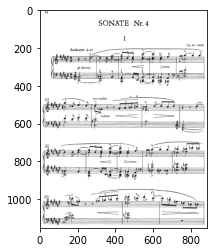

In [42]:
img2 = cv2.imread('sample_score2.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap = plt.cm.gray)
print(img2.shape)

In [43]:
test = GetLineImages(img2)

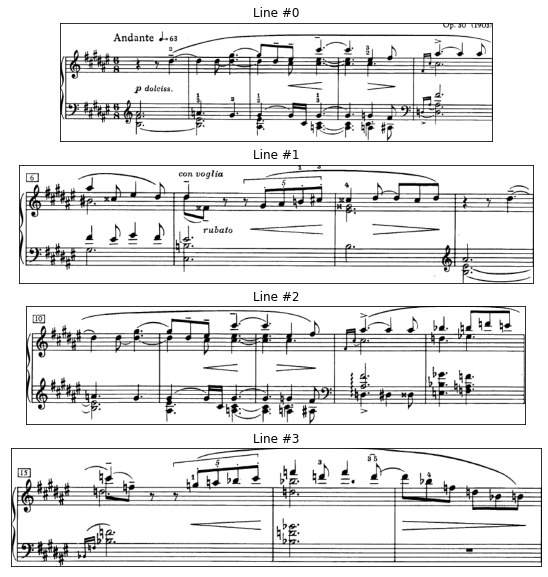

In [44]:
fig, ax = plt.subplots(len(test), figsize=(15,10))
for line in np.arange(len(test)):
    ax[line].imshow(test[line], cmap = plt.cm.gray)
    ax[line].imshow(test[line], cmap = plt.cm.gray)
    ax[line].set_xticks([])
    ax[line].set_yticks([])
    ax[line].title.set_text('Line #%d'%line)

As we can see the algorithm captures all the staff lines correctly. Another more complicated example:

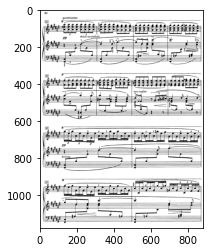

In [17]:
img3 = cv2.imread('sample_score3.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img3, cmap = plt.cm.gray)

In [18]:
test = GetLineImages(img3)

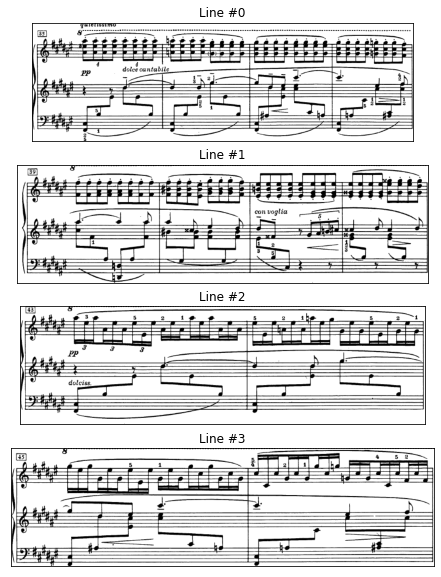

In [19]:
fig, ax = plt.subplots(len(test), figsize=(15,10))
for line in np.arange(len(test)):
    ax[line].imshow(test[line], cmap = plt.cm.gray)
    ax[line].imshow(test[line], cmap = plt.cm.gray)
    ax[line].set_xticks([])
    ax[line].set_yticks([])
    ax[line].title.set_text('Line #%d'%line)

We can also feed pdf files into the pipeline:

In [47]:
from pdf2image import convert_from_path
from PIL import ImageOps
images = convert_from_path('Sonata_No.4.pdf')
images = [ImageOps.grayscale(image) for image in images]
# images = [np.array(image)[::2,::2] for image in images] # downsampling

In [48]:
test = []
for i in range(len(images)):
    temp = GetLineImages(np.array(images[i]))
    test = [*test, *temp]
    print('Page %d finished'%(i+1))

Page 1 finished
Page 2 finished
Page 3 finished
Page 4 finished
Page 5 finished
Page 6 finished
Page 7 finished
Page 8 finished
Page 9 finished
Page 10 finished
Page 11 finished
Page 12 finished
Page 13 finished
Page 14 finished
Page 15 finished


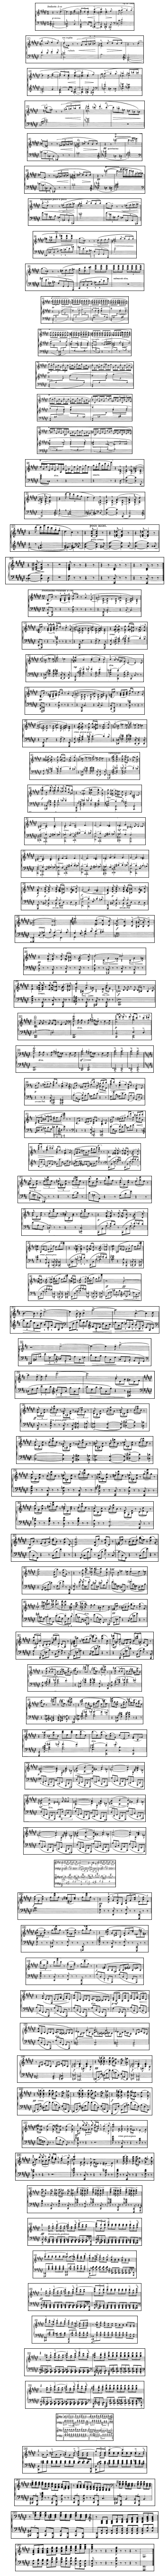

In [49]:
fig, ax = plt.subplots(len(test), figsize=(200,100))
for line in np.arange(len(test)):
    ax[line].imshow(test[line], cmap = plt.cm.gray)
    ax[line].imshow(test[line], cmap = plt.cm.gray)
    ax[line].set_xticks([])
    ax[line].set_yticks([])
    #ax[line].title.set_text('Line #%d'%line)